In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('../')

In [2]:
import numpy as np
import time
import logging
import scipy.sparse

In [3]:
from datasets import MovieLensGenreCastUserData

data = MovieLensGenreCastUserData(size="1m")
data.load()

idx = data.sample(factor_id=0, n_samples=300, seed=1000)
idx = data.sample(factor_id=1, n_samples=500, seed=1000)

data.Xs

[I] Sampling axis 0 to size 300
[I]   sampling seed: 1000
[I]   sampling from: (6040, 3706)
[I]   sampling to  : (300, 3706)
[I] Sampling axis 0 with given indices
[I]   sampling from: (6040, 82)
[I]   sampling to  : (300, 82)
[I] Sampling axis 1 to size 500
[I]   sampling seed: 1000
[I]   sampling from: (300, 3706)
[I]   sampling to  : (300, 500)
[I] Sampling axis 1 with given indices
[I]   sampling from: (41, 3706)
[I]   sampling to  : (41, 500)
[I] Sampling axis 1 with given indices
[I]   sampling from: (9488, 3706)
[I]   sampling to  : (9488, 500)


[<300x500 sparse matrix of type '<class 'numpy.int32'>'
 	with 7741 stored elements in Compressed Sparse Row format>,
 <300x82 sparse matrix of type '<class 'numpy.float64'>'
 	with 1124 stored elements in Compressed Sparse Row format>,
 <41x500 sparse matrix of type '<class 'numpy.float64'>'
 	with 1200 stored elements in Compressed Sparse Row format>,
 <9488x500 sparse matrix of type '<class 'numpy.float64'>'
 	with 2504 stored elements in Compressed Sparse Row format>]

In [4]:
from datasets import RatioSplit

s0 = RatioSplit(X=data.Xs[0], val_size=0.1, test_size=0.2, seed=1997)
s0.negative_sample(
    train_size=s0.pos_train_size, 
    val_size=s0.pos_val_size, 
    test_size=s0.pos_test_size, 
    seed=2023, type='popularity')

s1 = RatioSplit(X=data.Xs[1], val_size=0.1, test_size=0.2, seed=1997)
s1.negative_sample(
    train_size=s1.pos_train_size, 
    val_size=s1.pos_val_size, 
    test_size=s1.pos_test_size, 
    seed=2023, type='popularity')

s2 = RatioSplit(X=data.Xs[2], val_size=0.1, test_size=0.2, seed=1997)
s2.negative_sample(
    train_size=s2.pos_train_size, 
    val_size=s2.pos_val_size, 
    test_size=s2.pos_test_size, 
    seed=2023, type='popularity')

[I] RatioSplit, sampling positives
[I]   seed         : 1997
[I]   train_size   : 5417
[I]   val_size     : 775
[I]   test_size    : 1549
[I]   seed         : 1997
[I] RatioSplit, sampling negatives
[I]   seed         : 2023
[I]   all_negatives: 142259
[I]   n_negatives  : 7741
[I]   train_size   : 5417
[I]   val_size     : 775
[I]   test_size    : 1549
[I]   seed         : 2023
[I] RatioSplit, sampling positives
[I]   seed         : 1997
[I]   train_size   : 786
[I]   val_size     : 113
[I]   test_size    : 225
[I]   seed         : 1997
[I] RatioSplit, sampling negatives
[I]   seed         : 2023
[I]   all_negatives: 23476
[I]   n_negatives  : 1124
[I]   train_size   : 786
[I]   val_size     : 113
[I]   test_size    : 225
[I]   seed         : 2023
[I] RatioSplit, sampling positives
[I]   seed         : 1997
[I]   train_size   : 840
[I]   val_size     : 120
[I]   test_size    : 240
[I]   seed         : 1997
[I] RatioSplit, sampling negatives
[I]   seed         : 2023
[I]   all_negative

In [5]:
Xs_train = [s0.X_train, s1.X_train, s2.X_train]
Xs_val = [s0.X_val, s1.X_val, s2.X_val]
Xs_test = [s0.X_test, s1.X_test, s2.X_test]

# CMF vincent

In [6]:
from models.cmf_vincent.anewton import *
from models.cmf_vincent.utils import *
from models.cmf_vincent.cmf import *

class Args():
    def __init__(self, k, iter, user=0, item=0):
        self.train = "../models/cmf_vincent/data/ml-1m/train.txt"
        self.test = "../models/cmf_vincent/data/ml-1m/test.txt"
        self.item = "../models/cmf_vincent/data/ml-1m/item.txt" if item > 0 else ""
        self.user = "../models/cmf_vincent/data/ml-1m/user.txt" if user > 0 else ""
        self.out = "./out-cmf.txt"
        self.link = 'log_dense'
        self.alphas = '0.33'
        if user > 0:
            self.alphas += '-' + str(user)
        if item > 0:
            self.alphas += '-' + str(item)
        self.k = k
        self.reg = 0.1
        self.lr = 0.1
        self.iter = iter
        self.tol = 0.0
        self.verbose = True
        self.boolean = True
        
args = Args(k=5, iter=50, user=0.33, item=0.33)

In [7]:
[Xs_trn, Xs_tst, rc_schema, modes] = read_triple_data(
    args.train, args.test, args.user, args.item, args.link, args.boolean)

display([Xs_trn, Xs_tst, rc_schema, modes])

[[<6040x3883 sparse matrix of type '<class 'numpy.int32'>'
  	with 900188 stored elements in Compressed Sparse Column format>,
  <6040x29 sparse matrix of type '<class 'numpy.float64'>'
  	with 13789 stored elements in Compressed Sparse Column format>,
  <3883x99 sparse matrix of type '<class 'numpy.float64'>'
  	with 10291 stored elements in Compressed Sparse Column format>],
 [<6040x3883 sparse matrix of type '<class 'numpy.int32'>'
  	with 100021 stored elements in Compressed Sparse Column format>,
  None,
  None],
 array([[0, 1],
        [0, 2],
        [1, 3]]),
 ['sparse', 'log_dense', 'log_dense']]

In [31]:
Us = run_cmf(Xs_trn, Xs_tst, rc_schema, modes, args.alphas, args, logger=None, cmf_model=None)

AssertionError: 

In [8]:
class cmf_vincent(BaseCollectiveModel):
     def __init__(self) -> None:
          pass
     
     def predict_Xs(self):
        if not hasattr(self, 'Xs'):
            self.Xs_pd = [None] * self.n_matrices
        for i, factors in enumerate(self.factors):
            a, b = factors
            X = matmul(U=self.Us[a], V=self.Us[b].T, boolean=False, sparse=False)

            X = sigmoid(X.toarray())
            # self.Xs_pd[i] = binarize(X)

            self.Xs_pd[i] = X

d:\Dropbox\PyBMF\examples\..\utils\display.py:146: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, cnum).copy()
d:\Dropbox\PyBMF\examples\..\utils\display.py:146: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, cnum).copy()
d:\Dropbox\PyBMF\examples\..\utils\display.py:146: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, cnum).copy()


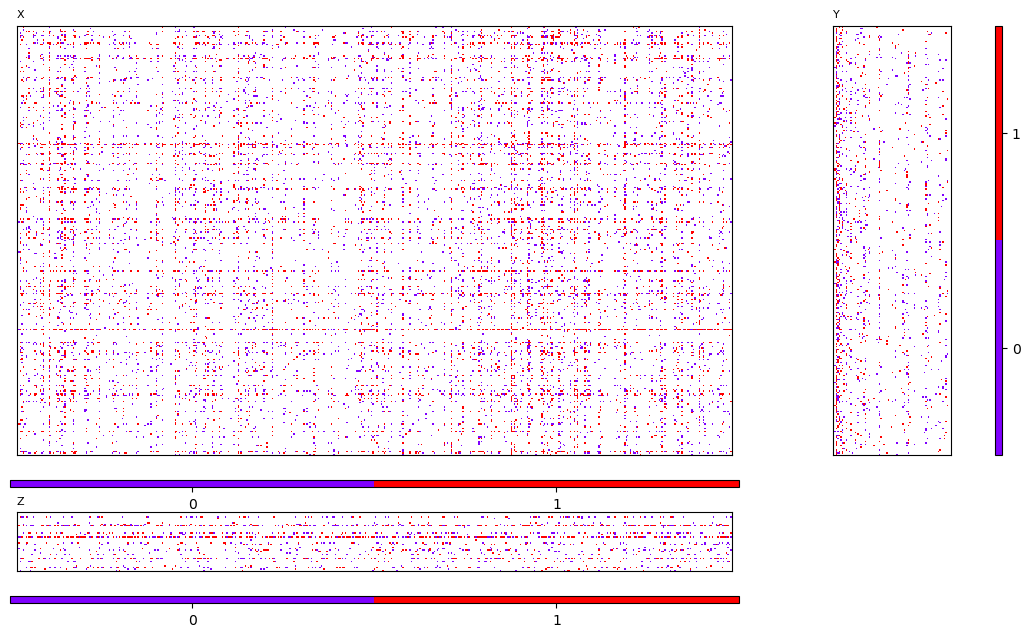

[INFO] ------------------- CMF -------------------
[INFO] Data: Number of instnace for each entity = [300, 500, 82, 41]
[INFO] Data: Training size = 10834. Testing size = 1550
[INFO] Settings: k = 5. reg = 0.1. lr = 0.1. alpha = [0.33, 0.33, 0.33]. modes = ['log_dense', 'log_dense', 'log_dense'].


[W] Missing testing data.
4 5


AssertionError: 

In [27]:
Xs_trn = Xs_train
Xs_tst = Xs_val
rc_schema = np.array([[0, 1], [0, 2], [3, 1]])
modes = ['log_dense', 'log_dense', 'log_dense']

show_matrix([(Xs_trn[0], [0, 0], 'X'), (Xs_trn[1], [0, 1], 'Y'), (Xs_trn[2], [1, 0], 'Z')], colorbar=True, discrete=True, center=True, clim=[0, 1])

if(args.verbose == 1):
    logging.basicConfig(level=logging.INFO, format='[%(levelname)s] %(message)s')
else:
    logging.basicConfig(level=logging.WARNING, format='[%(levelname)s] %(message)s')

logger = logging.getLogger()
[S, Ns] = get_config(Xs_trn, rc_schema)
alphas = string2list(args.alphas, len(modes))

logger.info('------------------- CMF -------------------')
logger.info('Data: Number of instnace for each entity = {}'.format(list(Ns)))
logger.info('Data: Training size = {}. Testing size = {}'.format(Xs_trn[0].size, Xs_tst[0].size))
logger.info('Settings: k = {}. reg = {}. lr = {}. alpha = {}. modes = {}.'.format(args.k, args.reg, args.lr, alphas, modes))

model = cmf_vincent()
modes = ['log_dense', 'log_dense', 'log_dense']
model.load_dataset(Xs_train=Xs_trn, factors=rc_schema.tolist(), Xs_val=Xs_tst)
model.import_model(verbose=False)
model.import_model(k=args.k, display=True, task='prediction', p=alphas)
model.init_model()

Us = run_cmf(Xs_trn, Xs_tst, rc_schema, modes, alphas, args, logger, model)

In [ ]:
model.predict_Xs()

d:\Dropbox\PyBMF\examples\..\utils\common.py:78: RuntimeWarning: overflow encountered in exp
  Y = 1.0 / (1.0 + np.exp(-X))


In [15]:
Us[2].shape

(82, 5)

d:\Dropbox\PyBMF\examples\..\utils\display.py:146: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, cnum).copy()
d:\Dropbox\PyBMF\examples\..\utils\display.py:146: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, cnum).copy()


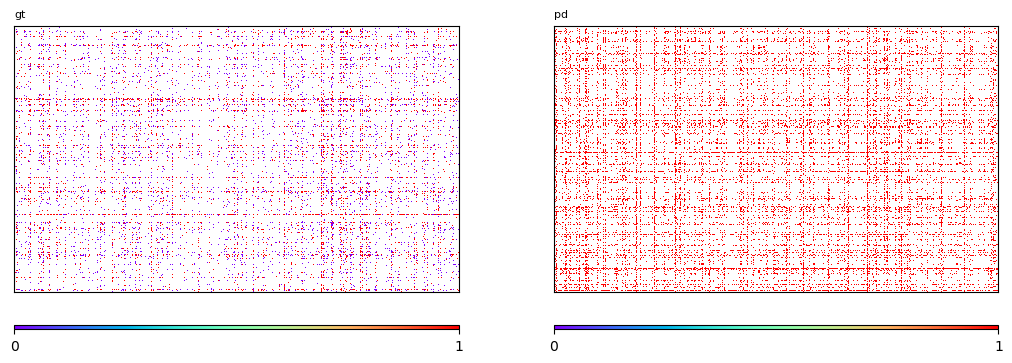

In [28]:
from utils import show_matrix
from scipy.sparse import csc_matrix, csr_matrix

W = model.Xs_train[0].copy()
W.data = np.ones(W.data.shape)

X_gt = model.Xs_train[0]

X_pd =  Us[0] @ Us[1].T
# X_pd = csr_matrix(W.toarray() * X_pd)
X_pd = binarize(X_pd, 1.9)
X_pd = csr_matrix(X_pd)

show_matrix([(X_gt, [0, 0], 'gt'), (X_pd, [0, 1], 'pd')], colorbar=True, clim=[0, 1])

In [ ]:
model.Xs_pd[0]

array([[1, 0, 0, ..., 1, 1, 1],
       [1, 1, 0, ..., 1, 1, 1],
       [1, 0, 1, ..., 0, 0, 1],
       ...,
       [1, 1, 0, ..., 1, 1, 1],
       [1, 0, 0, ..., 1, 1, 1],
       [1, 1, 1, ..., 0, 1, 0]])

In [ ]:
# from utils import log2latex
# log2latex(model, 'updates', open_browser=False)

In [ ]:
# from utils import log2html
# log2latex(model, 'updates')

# CMF

In [ ]:
from scipy.sparse import csc_matrix

X = csc_matrix(np.array([[1, 0, 2], [0, 3, 0]]))
data, indptr, indices = X.data, X.indptr, X.indices 

for r in range(3):
    ind_i0, ind_i1 = indptr[r], indptr[r + 1]
    inds_i = indices[ind_i0:ind_i1]
    print(inds_i)

[0]
[1]
[0]


In [ ]:
from scipy.sparse import csr_matrix

X = csr_matrix(np.array([[1, 0, 2], [0, 3, 0]]))
data, indptr, indices = X.data, X.indptr, X.indices 

for r in range(2):
    ind_i0, ind_i1 = indptr[r], indptr[r + 1]
    inds_i = indices[ind_i0:ind_i1]
    print(inds_i)

[0 2]
[1]


In [ ]:
from models import CMF

k = 5
p = [0.33, 0.33, 0.33]
Ws = 1
link = ['logistic', 'logistic', 'logistic']
lr = 0.1
reg = 0.1
tol = 0.0
max_iter = 50
init_method = 'normal'
seed = 2024

factors = [[0, 1], [0, 2], [3, 1]]

model = CMF(k=k, p=p, Ws=Ws, link=link, lr=lr, reg=reg, tol=tol, max_iter=max_iter, init_method=init_method, seed=seed)
model.fit(Xs_train=Xs_train, factors=factors, X_val=Xs_val, X_test=Xs_test, task='prediction', verbose=False, display=False)

[I] seed         : 2024
[I] verbose      : False
[I] display      : False
[I] k            : 5
[I] p            : [0.33, 0.33, 0.33]
[I] Ws           : 1
[I] link         : ['logistic', 'logistic', 'logistic']
[I] lr           : 0.1
[I] reg          : 0.1
[I] tol          : 0.0
[I] max_iter     : 50
[I] init_method  : normal
[I] task         : prediction
[W] Missing validation data.
[W] Missing testing data.
[I] error: 1.447e+04, rec_error: 1.447e+04, reg_error: 9.732e-01, rmse: 2.508e+00
[I] error: 1.043e+04, rec_error: 1.043e+04, reg_error: 1.510e+00, rmse: 2.124e+00
[I] error: 7.643e+03, rec_error: 7.641e+03, reg_error: 1.895e+00, rmse: 1.814e+00
[I] error: 5.741e+03, rec_error: 5.739e+03, reg_error: 2.202e+00, rmse: 1.569e+00
[I] error: 4.448e+03, rec_error: 4.445e+03, reg_error: 2.460e+00, rmse: 1.379e+00
[I] error: 3.569e+03, rec_error: 3.566e+03, reg_error: 2.684e+00, rmse: 1.234e+00
[I] error: 2.970e+03, rec_error: 2.967e+03, reg_error: 2.883e+00, rmse: 1.125e+00
[I] error: 2.5

# SimpleThresholding

In [ ]:
# from models import BaseCollectiveModel
# from utils import binarize, to_sparse
# from tqdm import tqdm

# class SimpleThresholding(BaseCollectiveModel):
#     def __init__(self, p):
#         self.check_params(p=p)

#     def fit(self, Xs_train, factors, Xs_val=None, Xs_test=None, **kwargs):
#         self.check_params(**kwargs)
#         self.load_dataset(Xs_train=Xs_train, factors=factors, Xs_val=Xs_val, Xs_test=Xs_test)
#         self.logs = {}



#         # self._fit()
            


#     def _fit(self, t, Us):
#         self.Us_ori = Us.copy()
#         for i in self.factor_list:
#             a, b = np.min(self.Us_ori[i]), np.max(self.Us_ori[i])
#             print([a, b])
#             self.Us_ori[i] = (self.Us_ori[i] - a) / (b - a)

        
#         while True:
#             for i, f in enumerate(self.factor_list):
#                 # for t in tqdm(np.linspace(0.05, 0.95, num=19), leave=False, desc=f"[I] factor: {i}"):
#                 #     self.Us[i] = to_sparse(binarize(self.Us_ori[i], threshold=t), 'lil')
#                 #     self.evaluate(df_name='updates', info={'factor': i, 't': t})
#                 self.Us[f] = to_sparse(binarize(self.Us_ori[f], threshold=t[i]), 'lil')
#             self.evaluate(df_name='updates', info={'factor': f, 't': 0.5})
#             break
                    
                

# bt = SimpleThresholding(p=[0.33, 0.33, 0.33])
# bt.Us=Us_ori
# bt.fit(Xs_train=Xs_trn, factors=[[0, 1], [0, 2], [3, 1]], Xs_val=Xs_tst, task='prediction', verbose=True)

[I] verbose      : False
[I] display      : False
[I] p            : [0.33, 0.33, 0.33]
[I] task         : prediction
[I] verbose      : True


In [ ]:
bt._fit(Us=Us, t=[0.5, 0.5, 0.5, 0.5])
from utils import log2html
log2html(bt, 'updates')

[-23.46890636612576, 20.789828056634484]
[-120.07002642661665, 198.04139763366283]
[-16.091845410301556, 2.0795320475917163]
[-1.9098789253432484, 5.424651634751139]


train                                \
                                        0                                 
                time factor    t   Recall Precision  Accuracy        F1   
3  20/03/24 05:50:08      3  0.5  0.00443  0.571429  0.500554  0.008793   
4  20/03/24 05:51:13      3  0.5  0.00443  0.571429  0.500554  0.008793   
5  20/03/24 05:51:21      3  0.5  0.00443  0.571429  0.500554  0.008793   
6  20/03/24 05:51:26      3  0.5  0.00443  0.571429  0.500554  0.008793   
7  20/03/24 05:51:34      3  0.5  0.00443  0.571429  0.500554  0.008793   

                             ...      val                                   \
       1                     ...        2     weighted                       
  Recall Precision Accuracy  ... Accuracy F1    Recall Precision  Accuracy   
3    1.0       0.5      0.5  ...      0.5  0  0.331703     0.385  0.495426   
4    1.0       0.5      0.5  ...      0.5  0  0.331703     0.385  0.495426   
5    1.0       0.5      0.5  ...      0.5  0  0.331703     0.385  0.495426   
6    1.0       0.5      0.5  ...      0.5  0  0.331703     0.385  0.495426   
7    1.0       0.5      0.5  ...      0.5  0  0.331703     0.385  0.495426   

                                              
           harmonic                           
        F1   Recall Precision  Accuracy   F1  
3  0.22338      0.0       0.0  0.500429  0.0  
4  0.22338      0.0       0.0  0.500429  0.0  
5  0.22338      0.0       0.0  0.500429  0.0  
6  0.22338      0.0       0.0  0.500429  0.0  
7  0.22338      0.0       0.0  0.500429  0.0  

[5 rows x 43 columns]

In [ ]:
from utils import log2html
log2html(bt, 'updates')